# 당뇨병 판정 하기

### 컬럼 정보

Pregnancies : Number of times pregnant 임신횟수

Glucose : 공복혈당 Plasma glucose concentration a 2 hours in an oral glucose tolerance test

BloodPressure : Diastolic blood pressure (mm Hg)

SkinThickness : Triceps skin fold thickness (mm)

Insulin : 2-Hour serum insulin (mu U/ml)

BMI : Body mass index (weight in kg/(height in m)^2)

Diabetes pedigree function

Age (years)

Outcome : class variable (0 or 1) 268 of 768 are 1, the others are 0

1이면 당뇨병이고, 0이면 당뇨병 아님

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
%matplotlib inline


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle
from lightgbm import LGBMClassifier


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
os.chdir('/content/drive/MyDrive/Colab Notebooks/k-digital/day20')

In [4]:
data = './diabetes.csv'

In [6]:
df = pd.read_csv(data)

In [7]:
df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


In [8]:
df.shape

(768, 9)

In [9]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

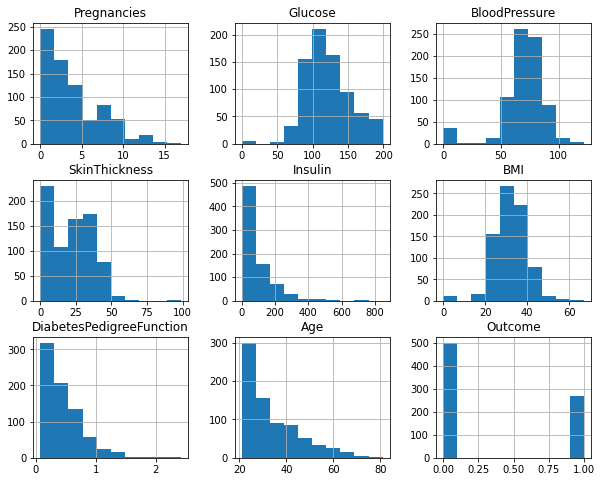

In [11]:
df.hist(figsize=(10,8))
plt.show()

In [12]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [14]:
df.loc[df['Insulin'] == 0, ] 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
764,2,122,70,27,0,36.8,0.340,27,0
766,1,126,60,0,0,30.1,0.349,47,1


# Feature Engineering

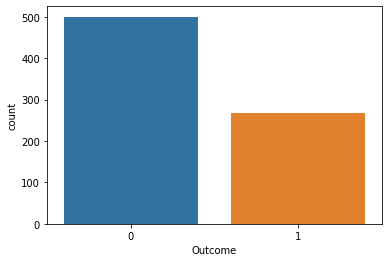

In [16]:
sns.countplot(data= df, x='Outcome')
plt.show()

### X, y 분리

In [17]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [19]:
X = df.iloc[ : ,0: -2+1]

In [20]:
y= df['Outcome']

### 각 컬럼에 0으로 채워진 데이터 처리

In [ ]:
# Nan으로 데이터가 들어있으면, 잘 처리해주는 함수인 dropna() 또는 fillna() 이런 함수를 이용해서 쉽게 데이터를 바꿀 수 있다.
# 하지만 지금의 문제는 데이터가 없는 곳에 Nan대신 0을 저장한 상태이므로, dropna, fillna로 데이터를 처리할 수 없다.

## 따라서 실무에서는 데이터가 비어있으면 데이터베이스에 null로 저장되도록 하세요. ##

In [21]:
from sklearn.impute import SimpleImputer

In [22]:
sl = SimpleImputer(missing_values=0)

In [23]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [25]:
X_sl = sl.fit_transform(X[['Glucose', 'BloodPressure', 'SkinThickness','BMI']])

In [26]:
X[['Glucose', 'BloodPressure', 'SkinThickness','BMI']] = X_sl

In [27]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,79.799479,32.457464,0.471876,33.240885
std,3.369578,30.435949,12.096346,8.790942,115.244002,6.875151,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,0.000000,18.200000,0.078000,21.000000
25%,1.000000,99.750000,64.000000,25.000000,0.000000,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.202592,29.153420,30.500000,32.400000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


### X, y 분리하고, 트레이닝 테스스트 셋 처리

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Model Building and Evaluation

In [29]:
import joblib
def FitModel(X_train,y_train,X_test,y_test,algo_name,algorithm,gridSearchParams,cv):
  np.random.seed(10)

  grid = GridSearchCV(algorithm, gridSearchParams, scoring='accuracy', n_jobs=-1, cv=cv, verbose=1)

  grid_result = grid.fit(X_train, y_train)

  best_params = grid_result.best_params_

  best_model = grid_result.best_estimator_

  joblib.dump(best_model, 'best_model.pkl')

  y_pred = grid_result.predict(X_test)

  cm = confusion_matrix(y_test, y_pred)

  print('y pred : ', y_pred)
  print('Best Params : ', best_params)
  print('Accuracy Score : ', accuracy_score(y_test, y_pred))
  print('Confusion Matrix : \n', cm)

# XgBoost

강의 노트 : https://docs.google.com/presentation/d/1pvgye0Gt5DKgA7Kn5pc4Cfy-D4VtmQTxVIvbxa-GfFc/edit#slide=id.gbebab87311_2_30

In [30]:
param = {'n_estimators' : [100,500], 'max_depth' : [3,4,5], 'learning_rate':[0.01, 0.1]}

In [31]:
FitModel(X_train, y_train, X_test, y_test, 'XGBoost', XGBClassifier(), param, 10)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
y pred :  [1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1
 1 0 0 0 1 0]
Best Params :  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Accuracy Score :  0.7207792207792207
Confusion Matrix : 
 [[79 16]
 [27 32]]


In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
scaler_X = MinMaxScaler()

In [34]:
X_train = scaler_X.fit_transform(X_train)

In [35]:
X_test = scaler_X.transform(X_test)

In [36]:
FitModel(X_train, y_train, X_test, y_test, 'XGBoost', XGBClassifier(), param, 10)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
y pred :  [1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1
 1 0 0 0 1 0]
Best Params :  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Accuracy Score :  0.7207792207792207
Confusion Matrix : 
 [[79 16]
 [27 32]]


# Random Forest

In [47]:
param = {'n_estimators' : [100, 200, 500, 1000, 1500]}

In [49]:
FitModel(X_train, y_train, X_test, y_test, 'Random Forest', RandomForestClassifier(), param, 10)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
y pred :  [1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0
 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0
 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1
 1 1 0 0 0 0]
Best Params :  {'n_estimators': 100}
Accuracy Score :  0.7337662337662337
Confusion Matrix : 
 [[83 12]
 [29 30]]


# SVC

In [63]:
param = {'C' : [0.1,1,10,100], 'gamma' : [0.0001, 0.001, 0.1, 0.005, 1]}


In [64]:
FitModel(X_train, y_train, X_test, y_test, 'SVC', SVC(), param, 10)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
y pred :  [1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1
 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0
 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1
 1 0 0 0 1 0]
Best Params :  {'C': 10, 'gamma': 0.1}
Accuracy Score :  0.7337662337662337
Confusion Matrix : 
 [[85 10]
 [31 28]]


# Balancing the Dataset - Over Sampling

In [50]:
from imblearn.over_sampling import SMOTE

In [51]:
sm = SMOTE(random_state=10)

In [53]:
X_res, y_res = sm.fit_resample(X, y)

In [55]:
X_res.shape

(1000, 8)

In [56]:
X.shape

(768, 8)

In [61]:
scaler_X = MinMaxScaler()

In [62]:
X_res = scaler_X.fit_transform(X_res)

# XgBoost  - After Over sampling

# Random Forest  - After Over sampling

# SVC  - After Over sampling